In [1]:
import os
from IPython.display import Image, display
import PIL
from PIL import ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import random
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow as tf
mirroted_strategy = tf.distribute.MirroredStrategy()

input_dir = "data_multi/raw/"
target_dir = "data_multi/mask/"
lp_dir = "data_multi/lp/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

lp_img_paths = sorted(
        [
        os.path.join(lp_dir, fname)
        for fname in os.listdir(lp_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:5], target_img_paths[:5]):
    print(input_path, "|", target_path)

2021-10-25 16:46:13.365647: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2021-10-25 16:46:14.406060: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-25 16:46:19.557020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-10-25 16:46:19.559553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-10-25 16:46:19.562312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:86:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-10-25

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of samples: 49902
data_multi/raw/0@14sep05c_00024sq_00003hl_00002es_c.mrcs.png | data_multi/mask/0@14sep05c_00024sq_00003hl_00002es_c.mrcs.png
data_multi/raw/0@14sep05c_00024sq_00003hl_00005es_c.mrcs.png | data_multi/mask/0@14sep05c_00024sq_00003hl_00005es_c.mrcs.png
data_multi/raw/0@14sep05c_00024sq_00004hl_00002es_c.mrcs.png | data_multi/mask/0@14sep05c_00024sq_00004hl_00002es_c.mrcs.png
data_multi/raw/0@14sep05c_00024sq_00006hl_00003es_c.mrcs.png | data_multi/mask/0@14sep05c_00024sq_00006hl_00003es_c.mrcs.png
data_multi/raw/0@14sep05c_c_00003gr_00014sq_00002hl_00005es_c.mrcs.png | data_multi/mask/0@14sep05c_c_00003gr_00014sq_00002hl_00005es_c.mrcs.png


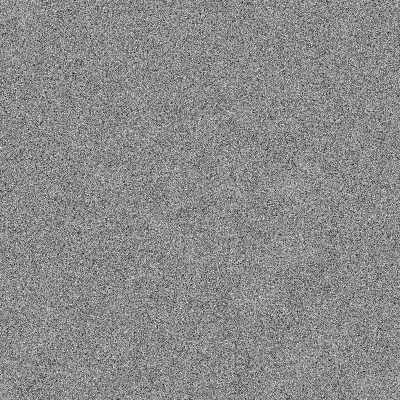

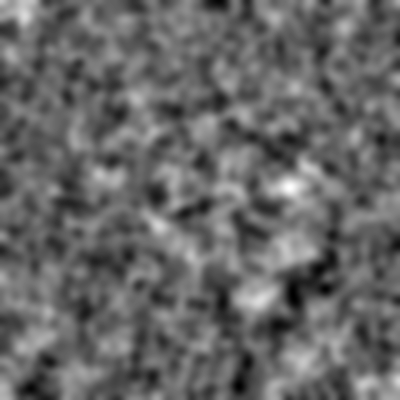

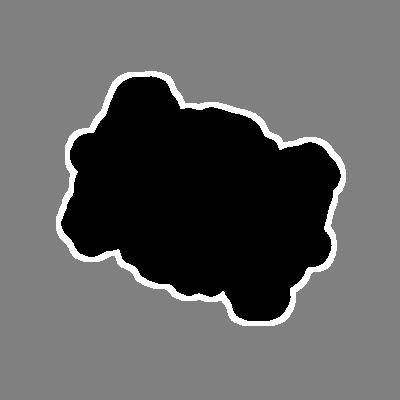

data_multi/raw/100@14sep05c_c_00003gr_00014sq_00005hl_00002es_c.mrcs.png
data_multi/mask/100@14sep05c_c_00003gr_00014sq_00005hl_00002es_c.mrcs.png


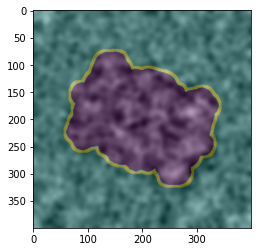

In [2]:
np.set_printoptions(threshold=sys.maxsize)

index_image = 202
# Display input image #7
display(Image(filename=input_img_paths[index_image]))

display(Image(filename=lp_img_paths[index_image]))
# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[index_image]))
display(img)


print(input_img_paths[index_image])
#plt.imshow(input_img_paths[0])
print(target_img_paths[index_image])

img_lp = mpimg.imread(lp_img_paths[index_image])
img_mask = PIL.Image.open(target_img_paths[index_image])
img_mask = img_mask.convert("L")
plt.imshow(img_lp)
plt.imshow(img_mask, alpha= 0.4, cmap='viridis')



In [3]:
class t20s_particles(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        shift_percent = 0.3
        shift_w = random.uniform(0, shift_percent)
        shift_y = random.uniform(0, shift_percent)
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            img = np.array(img)
            img = tf.keras.preprocessing.image.random_shift(img,shift_w, shift_y, row_axis=0, col_axis=1)
            x[j] = img
            
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.array(img)
            img = tf.keras.preprocessing.image.random_shift(img, shift_w, shift_y, row_axis=0, col_axis=1)
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # y[j][y[j] == 128] = 0
            y[j][y[j] == 128] = 1
            y[j][y[j] == 255] = 2
            #print(np.unique(y[j]))
        return x, y

class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)


In [4]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)


    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
with mirroted_strategy.scope():
    model = get_model(img_size, num_classes)
    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=[UpdatedMeanIoU(num_classes=3)])
#model = keras.models.load_model("oxford_segmentation.h5")
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [5]:

# Split our img paths into a training and a validation set
val_samples = 10000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = t20s_particles(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = t20s_particles(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [6]:
#opt = keras.optimizers.Adam(learning_rate=5e-4)


callbacks = [
    tf.keras.callbacks.ModelCheckpoint("particle_segmentation.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

2021-10-25 16:46:57.467972: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_4166"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key

Epoch 1/15
INFO:tensorflow:batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1


2021-10-25 16:47:28.162050: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-10-25 16:47:29.681286: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-10-25 16:47:31.831672: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-10-25 16:47:33.354886: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-25 16:47:35.675395: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-10-25 16:47:39.527881: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-10-25 16:47:40.283445: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202


 135/1246 [==>...........................] - ETA: 1:09:35 - loss: 0.4068 - updated_mean_io_u: 0.5292

KeyboardInterrupt: 

In [ ]:
# val_gen = t20s_particles(batch_size, img_size, val_input_img_paths[:200], val_target_img_paths[:200])
# val_preds = model.predict(val_gen)

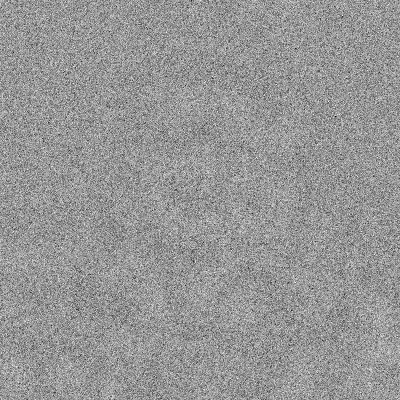

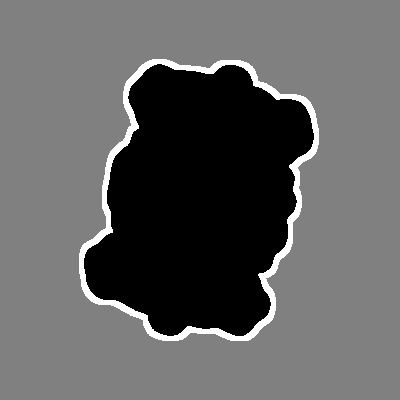

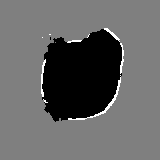

In [17]:
# def display_mask(i):
#     """Quick utility to display a model's prediction."""
#     mask = np.argmax(val_preds[i], axis=-1)
#     mask = np.expand_dims(mask, axis=-1)
#     img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
#     display(img)


# # Display results for validation image #10
# i = 5

# # Display input image
# display(Image(filename=val_input_img_paths[i]))

# # Display ground-truth target mask
# img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
# display(img)

# # Display mask predicted by our model
# display_mask(i)